<a href="https://colab.research.google.com/github/Ashraf1292/Thesis-Fake_jobs-/blob/main/98_version_time_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import html
from urllib.parse import urlparse

# For feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# For modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from lightgbm import LGBMClassifier

# For evaluation
from sklearn.metrics import (classification_report, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, confusion_matrix,
                             precision_recall_curve, auc)

# For handling imbalance
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# For model explanation
import shap

# For saving models
import joblib

# Download necessary NLTK resources
print("Downloading necessary NLTK resources...")
nltk_resources = ['punkt', 'stopwords', 'wordnet']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        print(f"{resource} already downloaded")
    except LookupError:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=True)
        print(f"{resource} download complete")

punkt download complete
stopwords download complete
wordnet download complete


In [ ]:
# 1. Data Loading & Exploration
print("\n1. Data Loading & Exploration")
# Load the dataset
df = pd.read_csv('fake_job_postings.csv')
print(f"Dataset shape: {df.shape}")

# Check class distribution
print("\nClass distribution:")
print(df['fraudulent'].value_counts())
print(f"Percentage of fraudulent jobs: {df['fraudulent'].mean() * 100:.2f}%")

# Check missing values
print("\nMissing values by column:")
print(df.isnull().sum())


1. Data Loading & Exploration
Dataset shape: (17880, 18)

Class distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64
Percentage of fraudulent jobs: 4.84%

Missing values by column:
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [ ]:
# 2. Data Preprocessing
print("\n2. Data Preprocessing")

def clean_html(text):
    """Remove HTML tags from text"""
    if isinstance(text, str):
        return re.sub(r'<.*?>', ' ', text)
    return ""

def clean_urls(text):
    """Remove URLs from text"""
    if isinstance(text, str):
        return re.sub(r'https?://\S+|www\.\S+', ' ', text)
    return ""

def extract_url_features(text):
    """Extract URL counts and features"""
    if not isinstance(text, str):
        return 0
    urls = re.findall(r'https?://\S+|www\.\S+', text)
    return len(urls)

def extract_email_features(text):
    """Extract email counts and features"""
    if not isinstance(text, str):
        return 0
    emails = re.findall(r'[\w.+-]+@[\w-]+\.[\w.-]+', text)
    return len(emails)

def count_suspicious_patterns(text):
    """Count suspicious patterns in text"""
    if not isinstance(text, str):
        return 0

    suspicious_patterns = [
        r'work\s+from\s+home', r'no\s+experience\s+needed', r'free',
        r'unlimited\s+earning', r'investment', r'money\s+back',
        r'earn\s+\$', r'earn\s+money', r'opportunity', r'urgently'
    ]

    count = 0
    for pattern in suspicious_patterns:
        matches = re.findall(pattern, text.lower())
        count += len(matches)

    return count

def preprocess_text(text):
    """Perform comprehensive text preprocessing"""
    if not isinstance(text, str):
        return ""

    # Convert HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = clean_html(text)

    # Remove URLs (after extracting features)
    text = clean_urls(text)

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Tokenize text
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()

    # Remove stopwords and short words
    try:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    except Exception as e:
        print(f"Error in stopwords/lemmatization: {e}")

    # Remove extra whitespace
    processed_text = ' '.join(tokens)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    return processed_text

# Apply preprocessing
print("Preprocessing text fields...")

# Fill missing text fields with empty strings
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_columns:
    df[col] = df[col].fillna('')

# Extract metadata features before cleaning
df['url_count'] = df['description'].apply(extract_url_features)
df['email_count'] = df['description'].apply(extract_email_features)
df['suspicious_count'] = df['description'].apply(count_suspicious_patterns)
df['title_length'] = df['title'].apply(len)
df['description_length'] = df['description'].apply(len)
df['capital_ratio'] = df['description'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / (len(x) if len(x) > 0 else 1) if isinstance(x, str) else 0
)

# Combine important text fields
df['combined_text'] = (
    df['title'] + ' ' +
    df['company_profile'] + ' ' +
    df['description'] + ' ' +
    df['requirements']
)

# Apply the preprocessing function
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Remove rows with empty processed text
df = df[df['processed_text'].str.strip() != '']
print(f"Dataset shape after preprocessing: {df.shape}")



2. Data Preprocessing
Preprocessing text fields...
Dataset shape after preprocessing: (17880, 26)


In [ ]:
# 3. Feature Engineering
print("\n3. Feature Engineering")

# A. Text vectorization
print("Vectorizing text...")

# Choose between TF-IDF or Transformer models
use_transformers = False  # Set to True to use BERT embeddings (much slower but potentially more accurate)

if use_transformers:
    try:
        # Using sentence-transformers
        model_name = 'all-MiniLM-L6-v2'  # Small but effective model
        print(f"Loading transformer model: {model_name}")
        model = SentenceTransformer(model_name)

        # Get embeddings (this can be slow)
        print("Generating embeddings - this may take a while...")
        embeddings = model.encode(df['processed_text'].tolist(), show_progress_bar=True)

        # Convert to DataFrame for easier manipulation
        embedding_df = pd.DataFrame(
            embeddings,
            columns=[f'embed_{i}' for i in range(embeddings.shape[1])]
        )

        # Join with original dataframe
        for col in embedding_df.columns:
            df[col] = embedding_df[col].values

        # Text features are the embeddings
        text_feature_cols = embedding_df.columns.tolist()

    except Exception as e:
        print(f"Error generating embeddings: {e}")
        print("Falling back to TF-IDF vectorization.")
        use_transformers = False

if not use_transformers:
    # Use TF-IDF instead
    tfidf_vectorizer = TfidfVectorizer(
        max_features=2000,  # Adjust based on available memory
        min_df=3,
        max_df=0.85,
        ngram_range=(1, 2)  # Include bigrams
    )

    # Fit and transform the processed text
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

    # Convert to DataFrame for easier manipulation
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
    )

    # Join with original dataframe (in practice, we'll keep them separate to save memory)
    # Instead of joining, we'll use these separately
    text_feature_cols = tfidf_df.columns.tolist()

    # Create a dictionary to store the feature values
    text_features = tfidf_matrix

# B. Metadata features
print("Extracting metadata features...")
metadata_cols = [
    'url_count', 'email_count', 'suspicious_count',
    'title_length', 'description_length', 'capital_ratio'
]

if 'telecommuting' in df.columns:
    df['telecommuting'] = df['telecommuting'].fillna(0)
    metadata_cols.append('telecommuting')

if 'has_company_logo' in df.columns:
    df['has_company_logo'] = df['has_company_logo'].fillna(0)
    metadata_cols.append('has_company_logo')

if 'has_questions' in df.columns:
    df['has_questions'] = df['has_questions'].fillna(0)
    metadata_cols.append('has_questions')

# Prepare target variable
y = df['fraudulent'].astype(int)




3. Feature Engineering
Vectorizing text...
Extracting metadata features...


In [ ]:
# 4. Prepare for Modeling
print("\n4. Preparing for Modeling")

# Split dataset
print("Splitting dataset...")
if use_transformers:
    # If using transformers, we already have the features in the dataframe
    X = df[text_feature_cols + metadata_cols].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
else:
    # For TF-IDF, we need to handle the sparse matrix separately
    metadata_features = df[metadata_cols].values

    # Create split indices
    train_indices, test_indices = train_test_split(
        np.arange(len(df)), test_size=0.2, random_state=42, stratify=y
    )

    # Split the data using indices
    X_text_train = text_features[train_indices]
    X_text_test = text_features[test_indices]
    X_meta_train = metadata_features[train_indices]
    X_meta_test = metadata_features[test_indices]
    y_train = y.iloc[train_indices].values
    y_test = y.iloc[test_indices].values

    # Convert sparse to dense if number of features is reasonable
    if X_text_train.shape[1] <= 2000:  # Only convert if dimensionality is reasonable
        X_text_train = X_text_train.toarray()
        X_text_test = X_text_test.toarray()

    # Combine text and metadata features
    if isinstance(X_text_train, np.ndarray):
        X_train = np.hstack((X_text_train, X_meta_train))
        X_test = np.hstack((X_text_test, X_meta_test))
    else:
        # This is a more complex case requiring specialized handling for sparse matrices
        # In real applications, we might use ColumnTransformer from sklearn
        # For simplicity, we convert to dense (be careful with memory usage!)
        X_text_train = X_text_train.toarray()
        X_text_test = X_text_test.toarray()
        X_train = np.hstack((X_text_train, X_meta_train))
        X_test = np.hstack((X_text_test, X_meta_test))

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")


4. Preparing for Modeling
Splitting dataset...
Training data shape: (14304, 2009)
Testing data shape: (3576, 2009)
Class distribution in training: [13611   693]


In [ ]:
# 5. Handle Class Imbalance with Partial Resampling
print("\n5. Handling Class Imbalance")

# Calculate initial class distribution
n_majority = np.sum(y_train == 0)
n_minority = np.sum(y_train == 1)
print(f"Original training distribution - Majority: {n_majority}, Minority: {n_minority}")

# Calculate target distribution for partial resampling
# Example: aiming for a 1:3 ratio of minority to majority
target_ratio = 3
target_minority = max(n_minority, n_majority // target_ratio)
# Convert to ratio for SMOTE sampling_strategy
sampling_strategy = min(1.0, target_minority / n_minority)

print(f"Using partial resampling with target ratio 1:{target_ratio}")
print(f"Sampling strategy: {sampling_strategy}")

# Choose resampling method based on the flag
resampling_method = "BorderlineSMOTE"  # Options: SMOTE, ADASYN, BorderlineSMOTE, SMOTETomek
print(f"Using {resampling_method} for resampling")

if resampling_method == "SMOTE":
    resampler = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
elif resampling_method == "ADASYN":
    resampler = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
elif resampling_method == "BorderlineSMOTE":
    resampler = BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42)
elif resampling_method == "SMOTETomek":
    resampler = SMOTETomek(sampling_strategy=sampling_strategy, random_state=42)
else:
    raise ValueError(f"Unknown resampling method: {resampling_method}")

# Apply resampling
X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

print(f"Resampled training shape: {X_resampled.shape}")
print(f"Class distribution after resampling: {np.bincount(y_resampled)}")


5. Handling Class Imbalance
Original training distribution - Majority: 13611, Minority: 693
Using partial resampling with target ratio 1:3
Sampling strategy: 1.0
Using BorderlineSMOTE for resampling
Resampled training shape: (27222, 2009)
Class distribution after resampling: [13611 13611]


In [ ]:
# 6. Model Training
print("\n6. Training Models")

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=5,  # Extra weight on minority class
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42
    )
}

# Train models
trained_models = {}
model_predictions = {}
model_probabilities = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_resampled, y_resampled)
    trained_models[name] = model

    # Make predictions
    y_pred = model.predict(X_test)
    model_predictions[name] = y_pred

    # Get probabilities for the positive class
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba
        y_prob = model.predict(X_test)
    model_probabilities[name] = y_prob

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Classification Report:\n{classification_report(y_test, y_pred)}")



6. Training Models
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Accuracy: 0.9541
  Precision: 0.5156
  Recall: 0.8613
  F1 Score: 0.6450
  ROC AUC: 0.9790
  Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3403
           1       0.52      0.86      0.65       173

    accuracy                           0.95      3576
   macro avg       0.75      0.91      0.81      3576
weighted avg       0.97      0.95      0.96      3576

Training Random Forest...
  Accuracy: 0.9757
  Precision: 0.8644
  Recall: 0.5896
  F1 Score: 0.7010
  ROC AUC: 0.9744
  Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.86      0.59      0.70       173

    accuracy                           0.98      3576
   macro avg       0.92      0.79      0.84      3576
weighted avg       0.97      0.98      0.97      3576

Training XGBoost...
  Accuracy: 0.9810
  Precision: 0.7966
  Recall: 0.8150
  F1 Sco

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 13611, number of negative: 13611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.797131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441142
[LightGBM] [Info] Number of data points in the train set: 27222, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# 7. Stacking Ensemble
print("\n7. Building Stacking Ensemble")

# Create a stacking ensemble
estimators = [(name, model) for name, model in trained_models.items()]
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    stack_method='predict_proba'
)

# Fit stacked model
print("Training stacking ensemble...")
stacked_model.fit(X_resampled, y_resampled)

# Make predictions
stacked_preds = stacked_model.predict(X_test)
stacked_probs = stacked_model.predict_proba(X_test)[:, 1]

# Calculate metrics
stacked_accuracy = accuracy_score(y_test, stacked_preds)
stacked_precision = precision_score(y_test, stacked_preds)
stacked_recall = recall_score(y_test, stacked_preds)
stacked_f1 = f1_score(y_test, stacked_preds)
stacked_roc_auc = roc_auc_score(y_test, stacked_probs)

print(f"Stacked Model Performance:")
print(f"  Accuracy: {stacked_accuracy:.4f}")
print(f"  Precision: {stacked_precision:.4f}")
print(f"  Recall: {stacked_recall:.4f}")
print(f"  F1 Score: {stacked_f1:.4f}")
print(f"  ROC AUC: {stacked_roc_auc:.4f}")
print(f"  Classification Report:\n{classification_report(y_test, stacked_preds)}")



7. Building Stacking Ensemble
Training stacking ensemble...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 13611, number of negative: 13611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.722486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441142
[LightGBM] [Info] Number of data points in the train set: 27222, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[LightGBM] [Info] Number of positive: 10889, number of negative: 10888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.594098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417377
[LightGBM] [Info] Number of data points in the train set: 21777, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10888, number of negative: 10889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.831913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416362
[LightGBM] [Info] Number of data points in the train set: 21777, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10889, number of negative: 10889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.619418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416711
[LightGBM] [Info] Number of data points in the train set: 21778, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10889, number of negative: 10889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.605960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416296
[LightGBM] [Info] Number of data points in the train set: 21778, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10889, number of negative: 10889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.621952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415783
[LightGBM] [Info] Number of data points in the train set: 21778, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacked Model Performance:
  Accuracy: 0.9838
  Precision: 0.8710
  Recall: 0.7803
  F1 Score: 0.8232
  ROC AUC: 0.9865
  Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.87      0.78      0.82       173

    accuracy                           0.98      3576
   macro avg       0.93      0.89      0.91      3576
weighted avg       0.98      0.98      0.98      3576



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



8. Optimizing Classification Threshold
Best model: Stacked Ensemble
Optimal threshold: 0.3364
Best F1-Score: 0.8314
Accuracy with Optimized Threshold: 98.3781%
Classification Report with Optimized Threshold:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.84      0.83      0.83       173

    accuracy                           0.98      3576
   macro avg       0.91      0.91      0.91      3576
weighted avg       0.98      0.98      0.98      3576



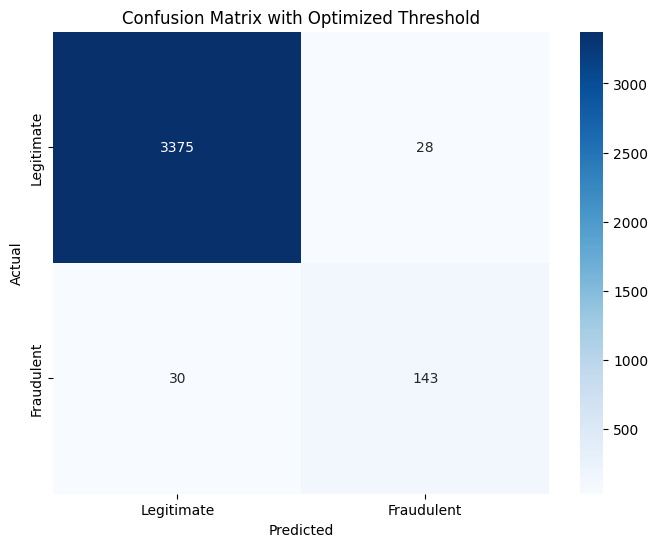

NameError: name 'roc_curve' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
# 8. Threshold Optimization
print("\n8. Optimizing Classification Threshold")

# Choose the best model based on F1 score
best_model_name = max(
    [(name, f1_score(y_test, preds)) for name, preds in model_predictions.items()],
    key=lambda x: x[1]
)[0]

# If stacked model is better, use it instead
stacked_f1 = f1_score(y_test, stacked_preds)
if stacked_f1 > max([f1_score(y_test, preds) for preds in model_predictions.values()]):
    best_model_name = "Stacked Ensemble"
    best_model = stacked_model
    best_probs = stacked_probs
else:
    best_model = trained_models[best_model_name]
    best_probs = model_probabilities[best_model_name]

print(f"Best model: {best_model_name}")

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, best_probs)
fscore = (2 * precision * recall) / (precision + recall + 1e-10)  # Add small epsilon to avoid div by zero
ix = np.argmax(fscore)
best_threshold = thresholds[ix]
print(f"Optimal threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {fscore[ix]:.4f}")

# Apply threshold
y_pred_optimized = (best_probs >= best_threshold).astype(int)

# Calculate accuracy
optimized_accuracy = accuracy_score(y_test, y_pred_optimized) * 100
print(f"Accuracy with Optimized Threshold: {optimized_accuracy:.4f}%")

print("Classification Report with Optimized Threshold:")
print(classification_report(y_test, y_pred_optimized))

# Create confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Optimized Threshold')
plt.savefig('confusion_matrix_optimized.png')
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 8))
for name, probs in model_probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Add stacked model
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=3, label=f'Stacked Ensemble (AUC = {roc_auc:.3f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curves.png')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
for name, probs in model_probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.3f})')

# Add stacked model
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=3, label=f'Stacked Ensemble (AUC = {pr_auc:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig('precision_recall_curves.png')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)



8. Optimizing Classification Threshold
Best model: Stacked Ensemble
Optimal threshold: 0.3364
Best F1-Score: 0.8314
Accuracy with Optimized Threshold: 98.3781%
Classification Report with Optimized Threshold:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.84      0.83      0.83       173

    accuracy                           0.98      3576
   macro avg       0.91      0.91      0.91      3576
weighted avg       0.98      0.98      0.98      3576



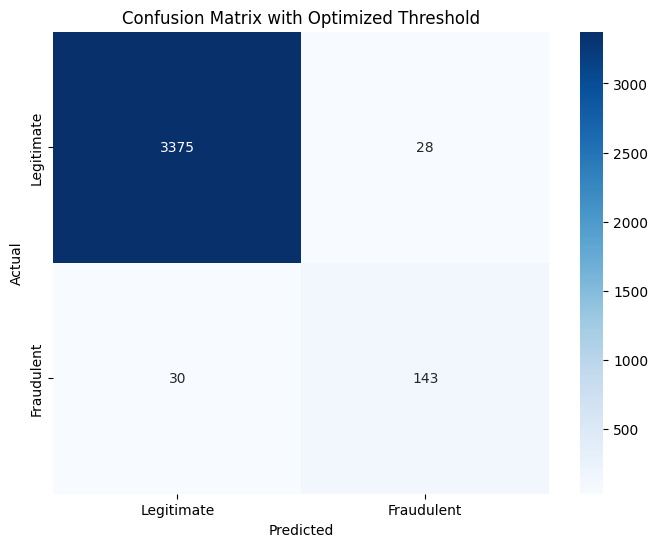

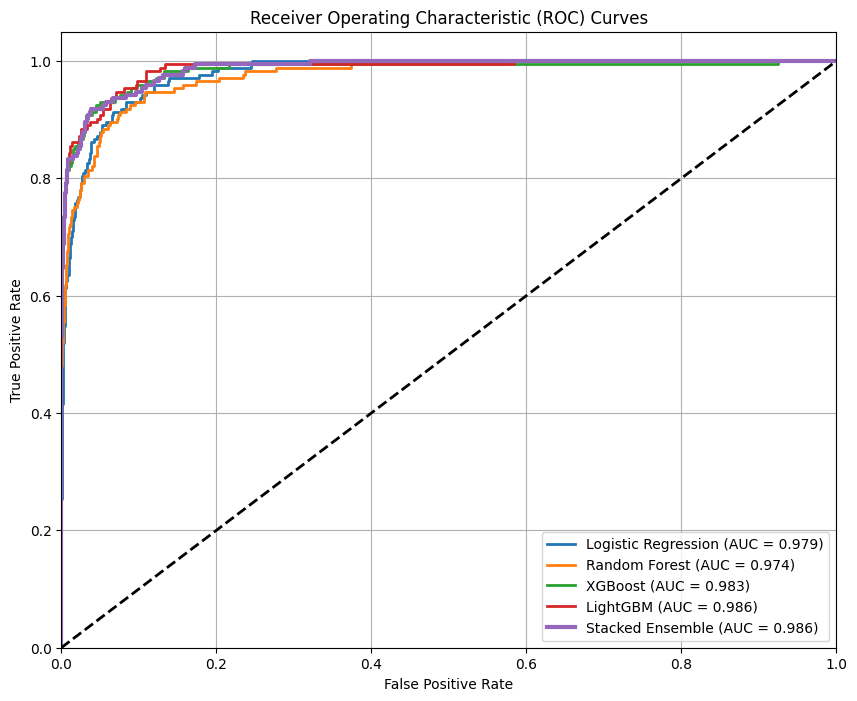

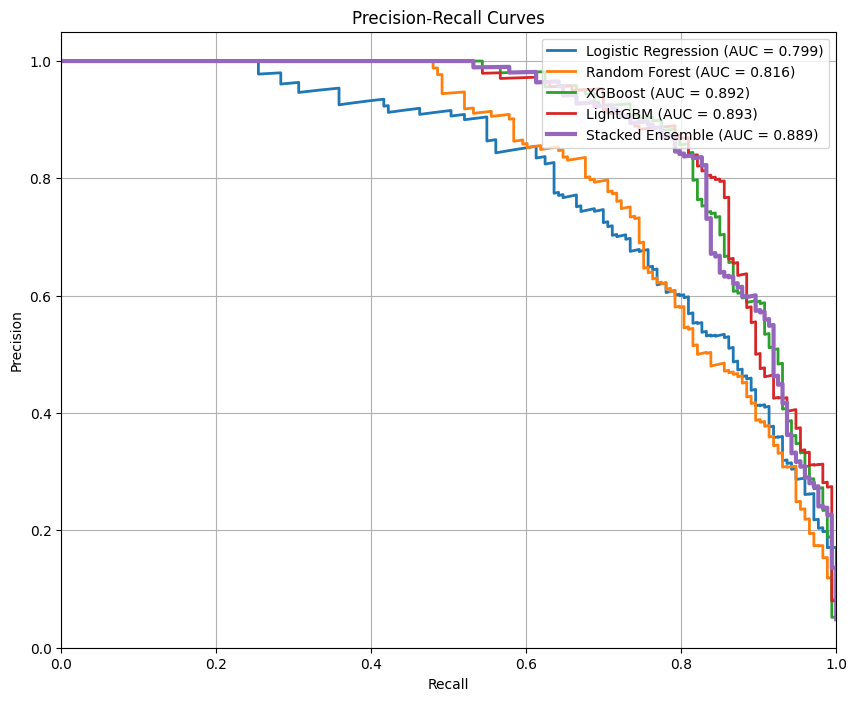

In [ ]:
# 8. Threshold Optimization
print("\n8. Optimizing Classification Threshold")

# Choose the best model based on F1 score
best_model_name = max(
    [(name, f1_score(y_test, preds)) for name, preds in model_predictions.items()],
    key=lambda x: x[1]
)[0]

# If stacked model is better, use it instead
stacked_f1 = f1_score(y_test, stacked_preds)
if stacked_f1 > max([f1_score(y_test, preds) for preds in model_predictions.values()]):
    best_model_name = "Stacked Ensemble"
    best_model = stacked_model
    best_probs = stacked_probs
else:
    best_model = trained_models[best_model_name]
    best_probs = model_probabilities[best_model_name]

print(f"Best model: {best_model_name}")

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, best_probs)
fscore = (2 * precision * recall) / (precision + recall + 1e-10)  # Add small epsilon to avoid div by zero
ix = np.argmax(fscore)
best_threshold = thresholds[ix]
print(f"Optimal threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {fscore[ix]:.4f}")

# Apply threshold
y_pred_optimized = (best_probs >= best_threshold).astype(int)

# Calculate accuracy
optimized_accuracy = accuracy_score(y_test, y_pred_optimized) * 100
print(f"Accuracy with Optimized Threshold: {optimized_accuracy:.4f}%")

print("Classification Report with Optimized Threshold:")
print(classification_report(y_test, y_pred_optimized))

# Create confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Optimized Threshold')
plt.savefig('confusion_matrix_optimized.png')
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 8))
for name, probs in model_probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Add stacked model
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=3, label=f'Stacked Ensemble (AUC = {roc_auc:.3f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curves.png')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
for name, probs in model_probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.3f})')

# Add stacked model
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, lw=3, label=f'Stacked Ensemble (AUC = {pr_auc:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig('precision_recall_curves.png')
plt.show()


In [ ]:
# 9. Model Interpretation with SHAP
print("\n9. Interpreting Model with SHAP")

# Use XGBoost model for SHAP analysis if it's available
try:
    if 'XGBoost' in trained_models:
        print("Analyzing feature importance with SHAP...")
        model_for_shap = trained_models['XGBoost']

        # Create explainer
        explainer = shap.TreeExplainer(model_for_shap)

        # Limit to a sample if dataset is large
        sample_size = min(500, X_test.shape[0])
        X_sample = X_test[:sample_size]

        # Calculate SHAP values
        shap_values = explainer.shap_values(X_sample)

        # Create feature names
        if use_transformers:
            feature_names = text_feature_cols + metadata_cols
        else:
            feature_names = [f"tfidf_{i}" for i in range(X_text_test.shape[1])] + metadata_cols

        # Plot summary
        try:
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
            plt.title('SHAP Feature Importance')
            plt.tight_layout()
            plt.savefig('shap_summary.png')
            plt.close()

            # Plot top 20 features
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False, max_display=20)
            plt.title('Top Features by SHAP Value')
            plt.tight_layout()
            plt.savefig('shap_top_features.png')
            plt.close()
        except Exception as e:
            print(f"Error generating SHAP plots: {e}")
    else:
        print("XGBoost model not available for SHAP analysis")
except Exception as e:
    print(f"Error in SHAP analysis: {e}")



9. Interpreting Model with SHAP
Analyzing feature importance with SHAP...


In [ ]:
# 10. Save Best Model
print("\n10. Saving Best Model")
try:
    joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl')

    # Save threshold info
    threshold_info = {
        'model_name': best_model_name,
        'best_threshold': best_threshold,
    }
    joblib.dump(threshold_info, 'threshold_info.pkl')

    print(f"Model and threshold info saved successfully")
except Exception as e:
    print(f"Error saving model: {e}")

print("\nFake Job Detection Pipeline Complete!")


10. Saving Best Model
Model and threshold info saved successfully

Fake Job Detection Pipeline Complete!
